## BPR simple

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
from subprocess import call
from pybpr import *
import matplotlib.pyplot as plt

In [3]:
cf = CFBase(
    users = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8],
    items = [1, 2, 3, 4, 5, 1, 2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 6, 7, 8, 9, 10,6, 7, 8, 9, 7, 8, 9, 10,7, 8, 9]
)
cf.generate_train_test(
    user_test_ratio=0.2,
    min_item_interactions=2
)

In [4]:
cf.R_train.toarray()

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]], dtype=int8)

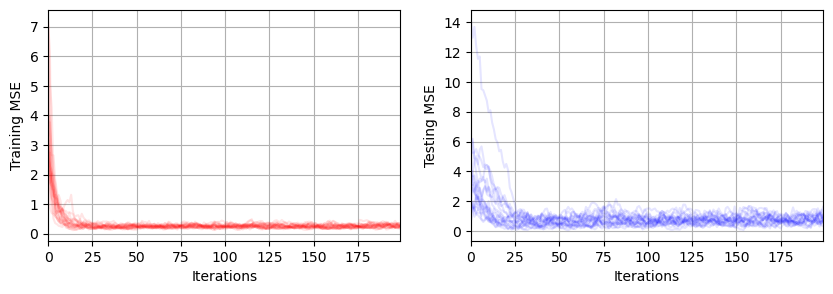

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
bpr = BPR(
    num_features = 3,
    num_users = cf.R.shape[0],
    num_items = cf.R.shape[1],
    reg_lambda=0.1,
    learning_rate=0.5
)
for _ in range(20):
    bpr.fit(cf.R_train, cf.R_test, num_iters=200, batch_size=1, seed=None)
    ax[0].plot(bpr.train_mse, '-r', alpha=0.1)
    ax[1].plot(bpr.test_mse, '-b', alpha=0.1)
ax[0].set_ylabel('Training MSE')
ax[1].set_ylabel('Testing MSE')
for iax in ax:
    iax.grid(True)
    iax.set_xlim([0, len(bpr.train_mse)-1])
    iax.set_xlabel('Iterations')
    #iax.set_xticks(np.arange(0,len(bpr.test_mse),5))

In [6]:
np.around(bpr.item_mat,1)
#np.around(bpr.user_mat,2)

array([[ 0.1, -0.6, -0.4],
       [-0.1, -0.4, -0.9],
       [ 0. , -0.3, -1. ],
       [ 0.6, -0.8, -0.1],
       [ 0.7, -0.9, -0.1],
       [-0.9,  0.2,  0.5],
       [ 0.5,  0.8,  0.3],
       [-0.3,  1. ,  0.7],
       [-0.9,  0.2,  0.6],
       [ 0.1,  0.3,  0.8]])

In [7]:
cf.get_top_items_for_this_user(0, bpr.user_mat, bpr.item_mat, 2)

[2, 9]

In [8]:
cf.get_similar(bpr.user_mat, for_this_inds=0, count=3)

[2, 1, 3]